## Author: Maryam Khanahmadi - Computational physicist - Postdocs at Chalmers University of thecnology
## Email: m.khanahmadi94@gmail.com
#### Data forcasting with LSTM cells and hyper parameter optimization methods

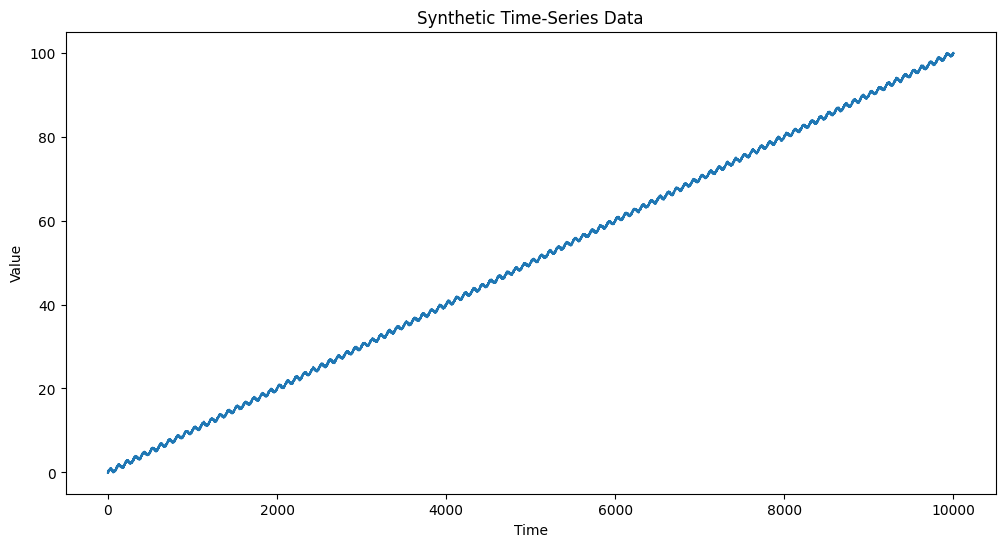

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
num_points = 10000  # Number of data points
period = 100        # Period of the sine wave
trend_slope = 0.01  # Trend slope

# Generate time points
time = np.arange(num_points)

# Generate synthetic data: trend + sine wave
trend = trend_slope * time
sine_wave = 0.5 * np.sin(2 * np.pi * time / period)
noise = np.random.normal(0, 0.1, num_points)  # Add some noise

# Create the time series data
data = trend + sine_wave + noise

# Create a DataFrame
df = pd.DataFrame(data, columns=['feature'])

# Save to CSV
df.to_csv('synthetic_time_series_data.csv', index=False)

# Plot the synthetic data
plt.figure(figsize=(12, 6))
plt.plot(time, data)
plt.title('Synthetic Time-Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [9]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the synthetic time-series data
df = pd.read_csv('synthetic_time_series_data.csv')

# Extract the feature
data = df['feature'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, sequence_length=30, forecast_steps=10):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_steps):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length:i + sequence_length + forecast_steps])
    return np.array(X), np.array(y)

sequence_length = 30
forecast_steps = 10
X, y = create_sequences(data_normalized, sequence_length=sequence_length, forecast_steps=forecast_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (6972, 30, 1)
y_train shape: (6972, 10, 1)
X_test shape: (2988, 30, 1)
y_test shape: (2988, 10, 1)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import keras_tuner as kt

# Define the model building function for KerasTuner
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=200, step=50), 
                   activation='relu', 
                   input_shape=(sequence_length, 1), 
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=200, step=50), 
                   activation='relu', 
                   return_sequences=False))
    model.add(Dense(forecast_steps))  # Predicting the next 10 time steps
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='mean_squared_error')
    return model

# Initialize KerasTuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_hyperparam_tuning'
)

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model on the full training data
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])

# Evaluate the model
loss = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')


Trial 10 Complete [00h 02m 37s]
val_loss: 1.2938464351464063e-05

Best val_loss So Far: 7.120075224520406e-06
Total elapsed time: 00h 24m 14s


/Users/maryamkhanahmadi/maryamenv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6152e-06
Test Loss: 0.0000


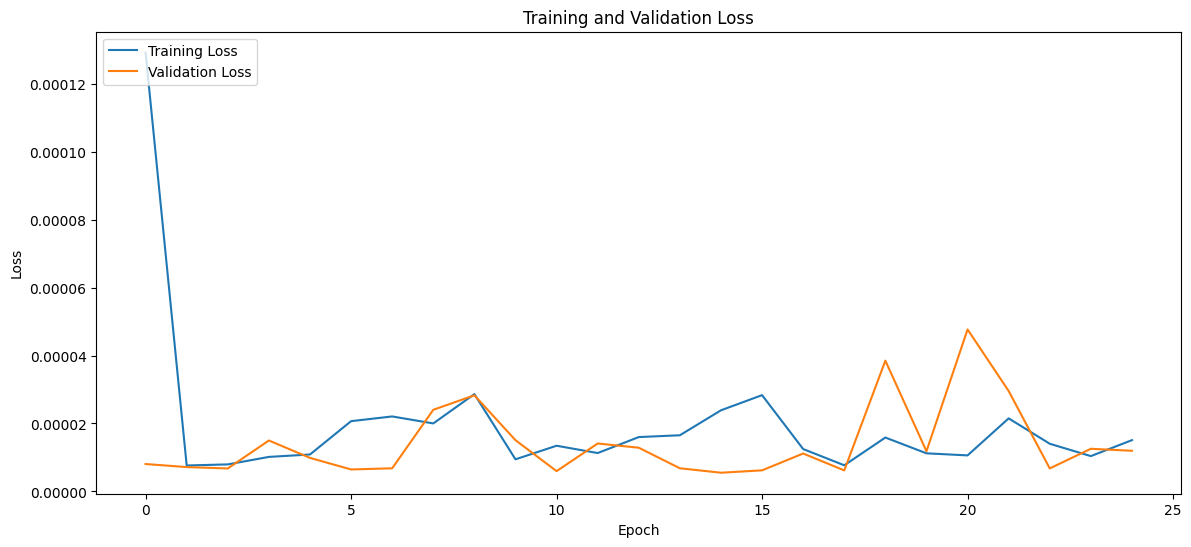

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
